In [1]:
import sys
sys.path.append('../')
from config import configuration
config = configuration()
config.request_password()

········


In [5]:
import sqlutilpy
data = pd.DataFrame(
         sqlutilpy.get('''select * from thomas_molnar.virac2_variable_data''',
                    **config.wsdb_kwargs)
       )

In [2]:
def get_lightcurve(sourceid):

    lcs = pd.DataFrame(sqlutilpy.get('''select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_variables where sourceid={0}'''.format(sourceid),
                     **config.wsdb_kwargs))
    
    return lcs

def get_lightcurve_bulk(sourceids):

    lcs = pd.DataFrame(sqlutilpy.get('''select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_variables where sourceid in ({0})'''.format((','.join(str(s) for s in sourceids))),
                     **config.wsdb_kwargs))
    
    return [x for _, x in lcs.groupby('sourceid')]

In [3]:
%matplotlib notebook

In [ ]:
fltr = (data['class']=='RRab')&(data['prob']>0.999)
sid=data['sourceid'][fltr].values
per=data['lsq_period'][fltr].values
per = per[np.argsort(sid)]
sid = sid[np.argsort(sid)]
lcs = get_lightcurve_bulk(sid)

<IPython.core.display.Javascript object>


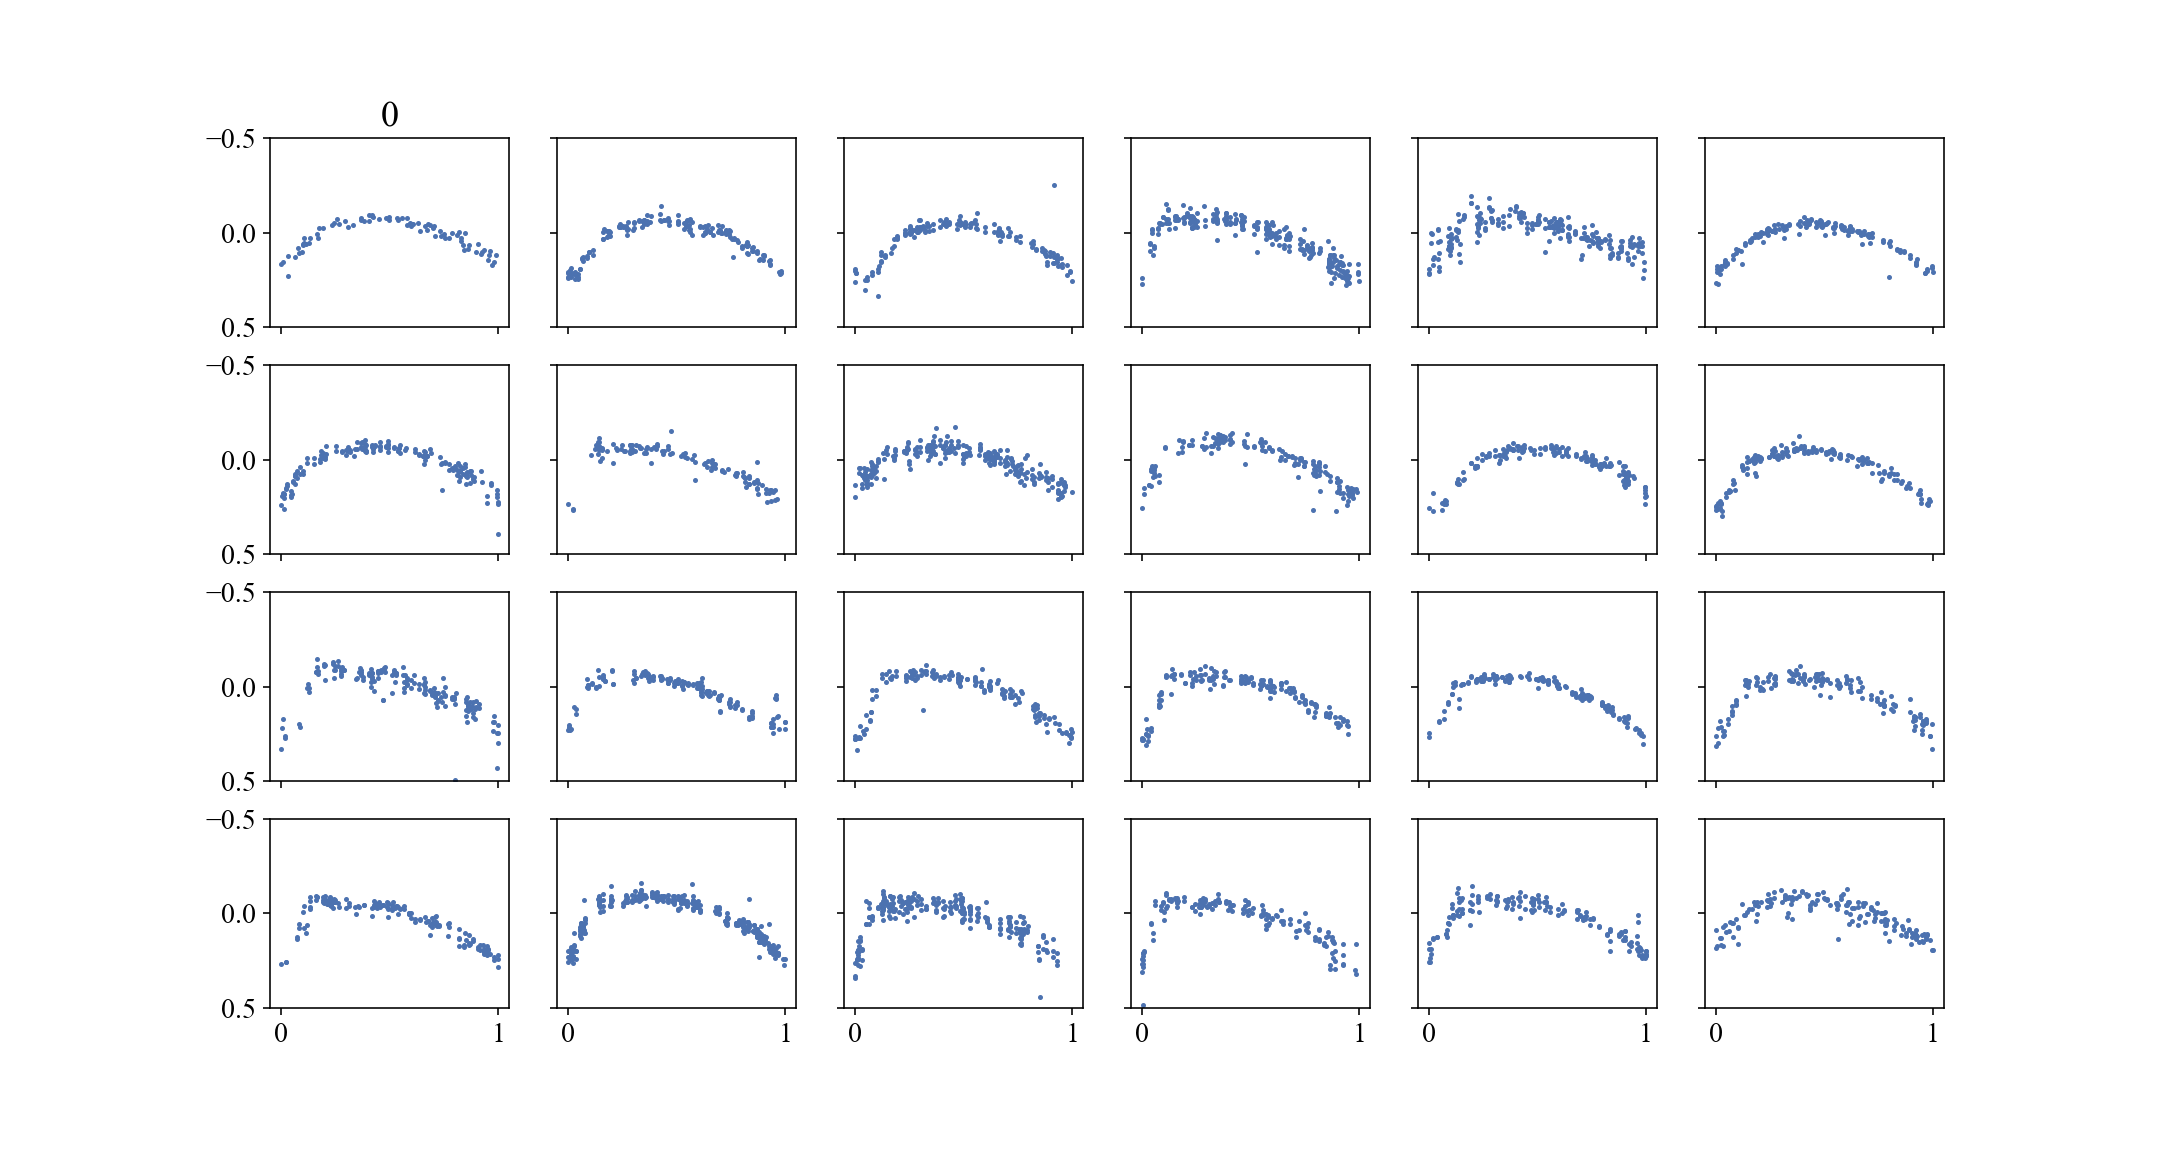

In [91]:
NY,NX=4,6
f,a=plt.subplots(NY,NX,figsize=[15,8],sharex=True,sharey=True)
a = a.flatten()

def plllt(lc,per,ax):
    plt.sca(ax)
    plt.cla()
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<13.)
    min_t = lc['mjdobs'][clean].values[np.argsort(lc['mag'][clean].values)[-3]]
    plt.plot(((lc['mjdobs'][clean]-min_t)%(per)/per),lc['mag'][clean]-np.nanmedian(lc['mag'][clean]),'.',
            ms=3)

event_subplots={}
chunk_index=0

def plot_grid(chunk):
    
    s = sid[chunk*NY*NX:(chunk+1)*NY*NX]
    p = per[chunk*NY*NX:(chunk+1)*NY*NX]
    lcss = lcs[chunk*NY*NX:(chunk+1)*NY*NX]
    
    global event_subplots
    event_subplots = {ss:l for l,ss in zip(s,a[:len(s)])}

    [plllt(lc,p,ax) for lc, p,ax in zip(lcs, p, a)]
    plt.ylim(-0.5,0.5)
    plt.sca(a[0])
    plt.title(chunk_index,fontsize=18)
    plt.gca().invert_yaxis()

import os
from functools import partial

def onclick(event):
    with open('tmp', 'a') as w:
        w.write('%i\n' % (event_subplots[event.inaxes]))

def on_press(event):
    sys.stdout.flush()
    global chunk_index
    if event.key == 'n':
        chunk_index+=1
        plot_grid(chunk_index)
        

plot_grid(0)
pid= f.canvas.mpl_connect('key_press_event', on_press)
cid = f.canvas.mpl_connect('button_press_event', onclick)

plt.show()

In [60]:
ff.close()

6498
False


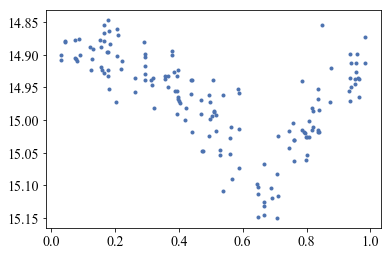

In [353]:
ii=32
prob_lower=0.989
prob_upper=0.999
fltr = (data['prob']>prob_lower)&(data['prob']<prob_upper)&(data['class']=='RRab')&(d2d.arcsec>0.4)
print(np.count_nonzero(fltr))
sid=data['sourceid'][fltr].values[ii]
per=data['lsq_period'][fltr].values[ii]
ph0=data['phi_0'][fltr].values[ii]
print(data['significant_second_minimum'][fltr].values[ii])
lc=get_lightcurve(sid)
plt.plot(lc['mjdobs'][lc['filterid']==5]%(per)/per,lc['mag'][lc['filterid']==5],'.')
plt.gca().invert_yaxis()

In [11]:
cpy = pd.read_csv('cpy_rr_v1.csv')

In [16]:
from astropy.coordinates import SkyCoord
import astropy.units as u
idx,d2d,_=SkyCoord(cpy['ra_k']*u.deg,cpy['dec_k']*u.deg).match_to_catalog_sky(SkyCoord(data['ra']*u.deg,data['dec']*u.deg))

In [137]:
cpy[d2d.arcsec>2.5]

Unnamed: 0              id  tile  cnt        ra_k      dec_k      prob  \
104     1258313  32470000165534  b247  136  270.346242 -35.321842  0.607467   

                                               tsample  
104  b206, b214, b216, b220, b228, b234, b248, b261...

In [98]:
mtch=data.iloc[idx].reset_index(drop=True)

In [140]:
np.count_nonzero(mtch['class']!='RRab')

99

In [153]:
np.min(data['phi_0'])

-3.141587

In [247]:
print(cid)

4


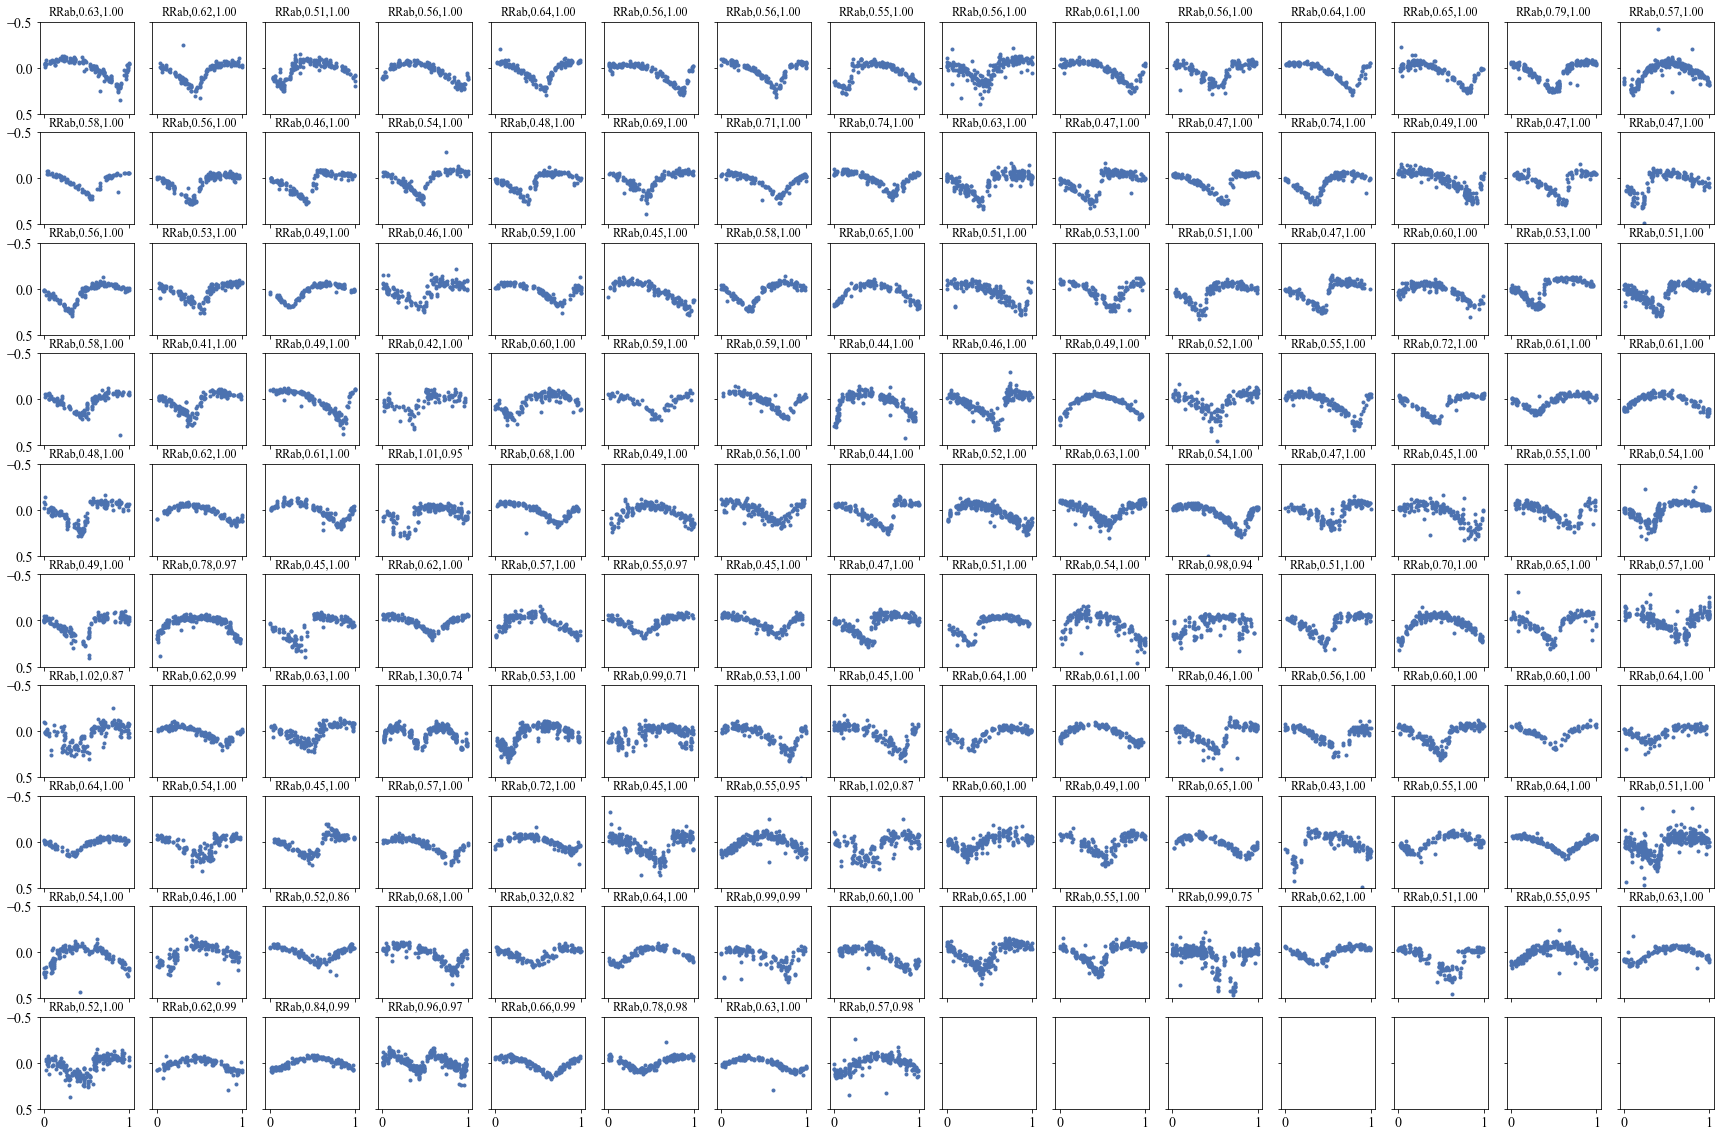

In [158]:
f,a=plt.subplots(10,15,figsize=[30,20],sharex=True,sharey=True)
a = a.flatten()
fltr = (mtch['class']=='RRab')
for ii in range(np.count_nonzero(fltr)):
    plt.sca(a[ii])
    sid,per,clss=mtch['sourceid'][fltr].values[ii],mtch['lsq_period'][fltr].values[ii],mtch['class'][fltr].values[ii]
    lc=get_lightcurve(sid)
    ph0,prb=mtch['phi_0'][fltr].values[ii],mtch['prob'][fltr].values[ii]
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<13.)#&(lc['chi']<3.)
    plt.plot((lc['mjdobs'][clean]%(per)/per),lc['mag'][clean]-np.nanmedian(lc['mag'][clean]),'.')
    plt.title('%s,%0.2f,%0.2f'%(clss,per,prb))
plt.ylim(-0.5,0.5)
plt.gca().invert_yaxis()

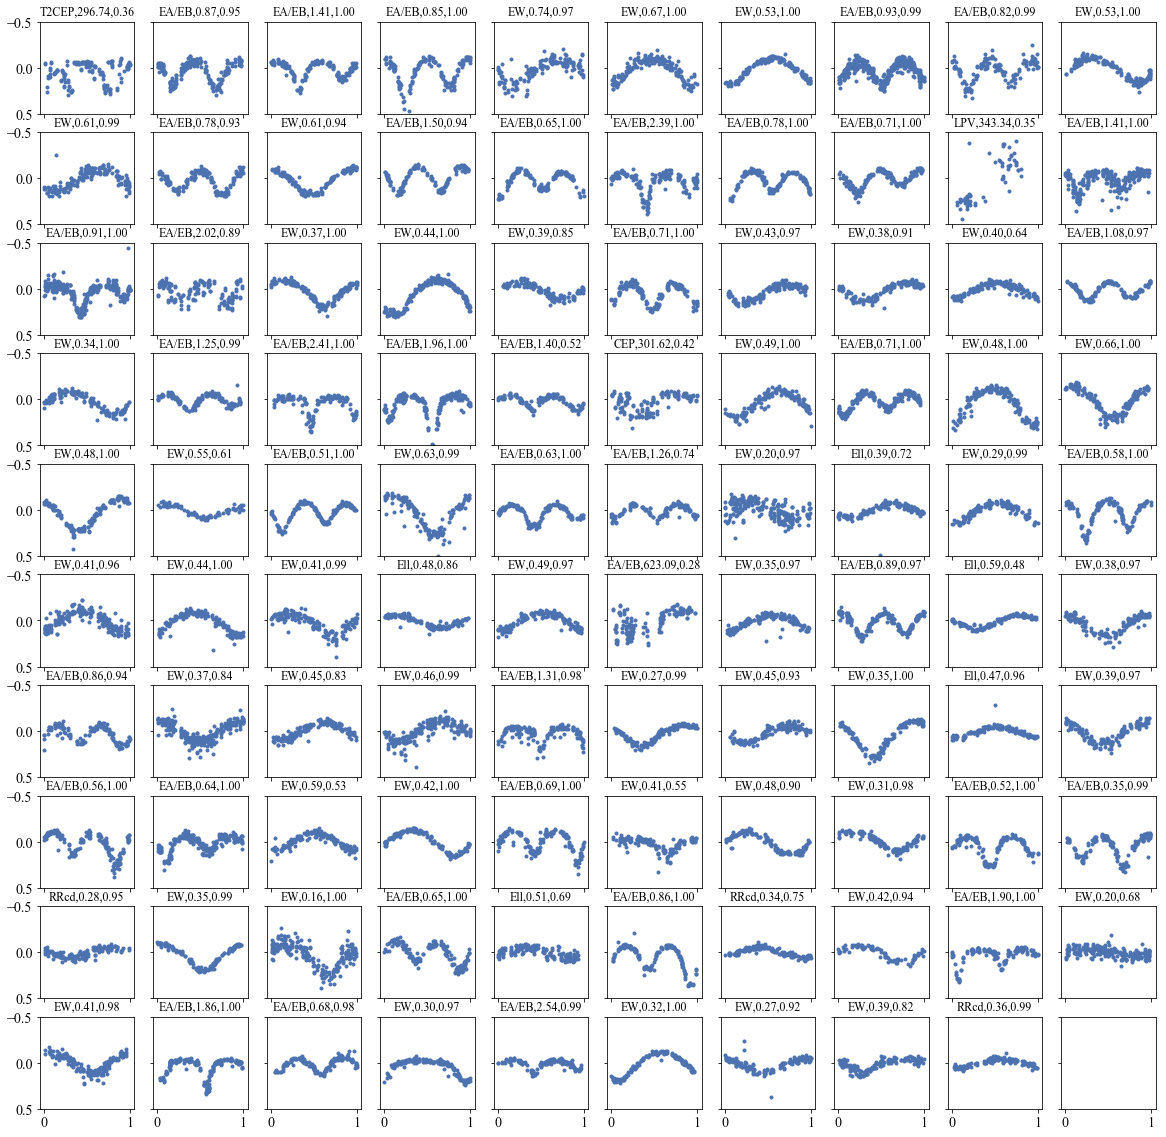

In [160]:
f,a=plt.subplots(10,10,figsize=[20,20],sharex=True,sharey=True)
a = a.flatten()
fltr = (mtch['class']!='RRab')
for ii in range(np.count_nonzero(fltr)):
    plt.sca(a[ii])
    sid,per,clss=mtch['sourceid'][fltr].values[ii],mtch['lsq_period'][fltr].values[ii],mtch['class'][fltr].values[ii]
    lc=get_lightcurve(sid)
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<13.)#&(lc['chi']<3.)
    prob=mtch['prob'][fltr].values[ii]
    plt.plot(lc['mjdobs'][clean]%(per)/per,lc['mag'][clean]-np.nanmedian(lc['mag'][clean]),'.')
    plt.title('%s,%0.2f,%0.2f'%(clss,per,prob))
plt.ylim(-0.5,0.5)
plt.gca().invert_yaxis()

213


(-19.2, -17.3)

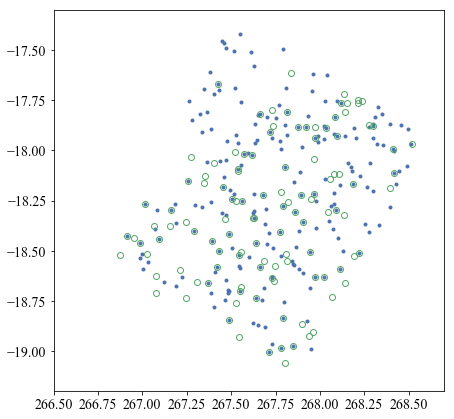

In [193]:
plt.figure(figsize=[7,7])
fltr = (data['class']=='RRab')&(data['b']>3.9)&(data['l']>9.1)&(data['l']<20.)
print(np.count_nonzero(fltr))
plt.plot(data['ra'].values[fltr],data['dec'].values[fltr],'.')
plt.plot(cpy['ra_k'],cpy['dec_k'],'o',mfc='none')
plt.xlim(266.5,268.7)
plt.ylim(-19.2,-17.3)

In [194]:
from astropy.coordinates import SkyCoord
import astropy.units as u
idx_2,d2d_2,_=SkyCoord(data[fltr]['ra'].values*u.deg,data[fltr]['dec'].values*u.deg).match_to_catalog_sky(SkyCoord(cpy['ra_k']*u.deg,cpy['dec_k']*u.deg))

In [202]:
unmatched=data[fltr].reset_index(drop=True)[d2d_2.arcsec>20.].reset_index(drop=True).sort_values(by='prob')[::-1].reset_index(drop=True)

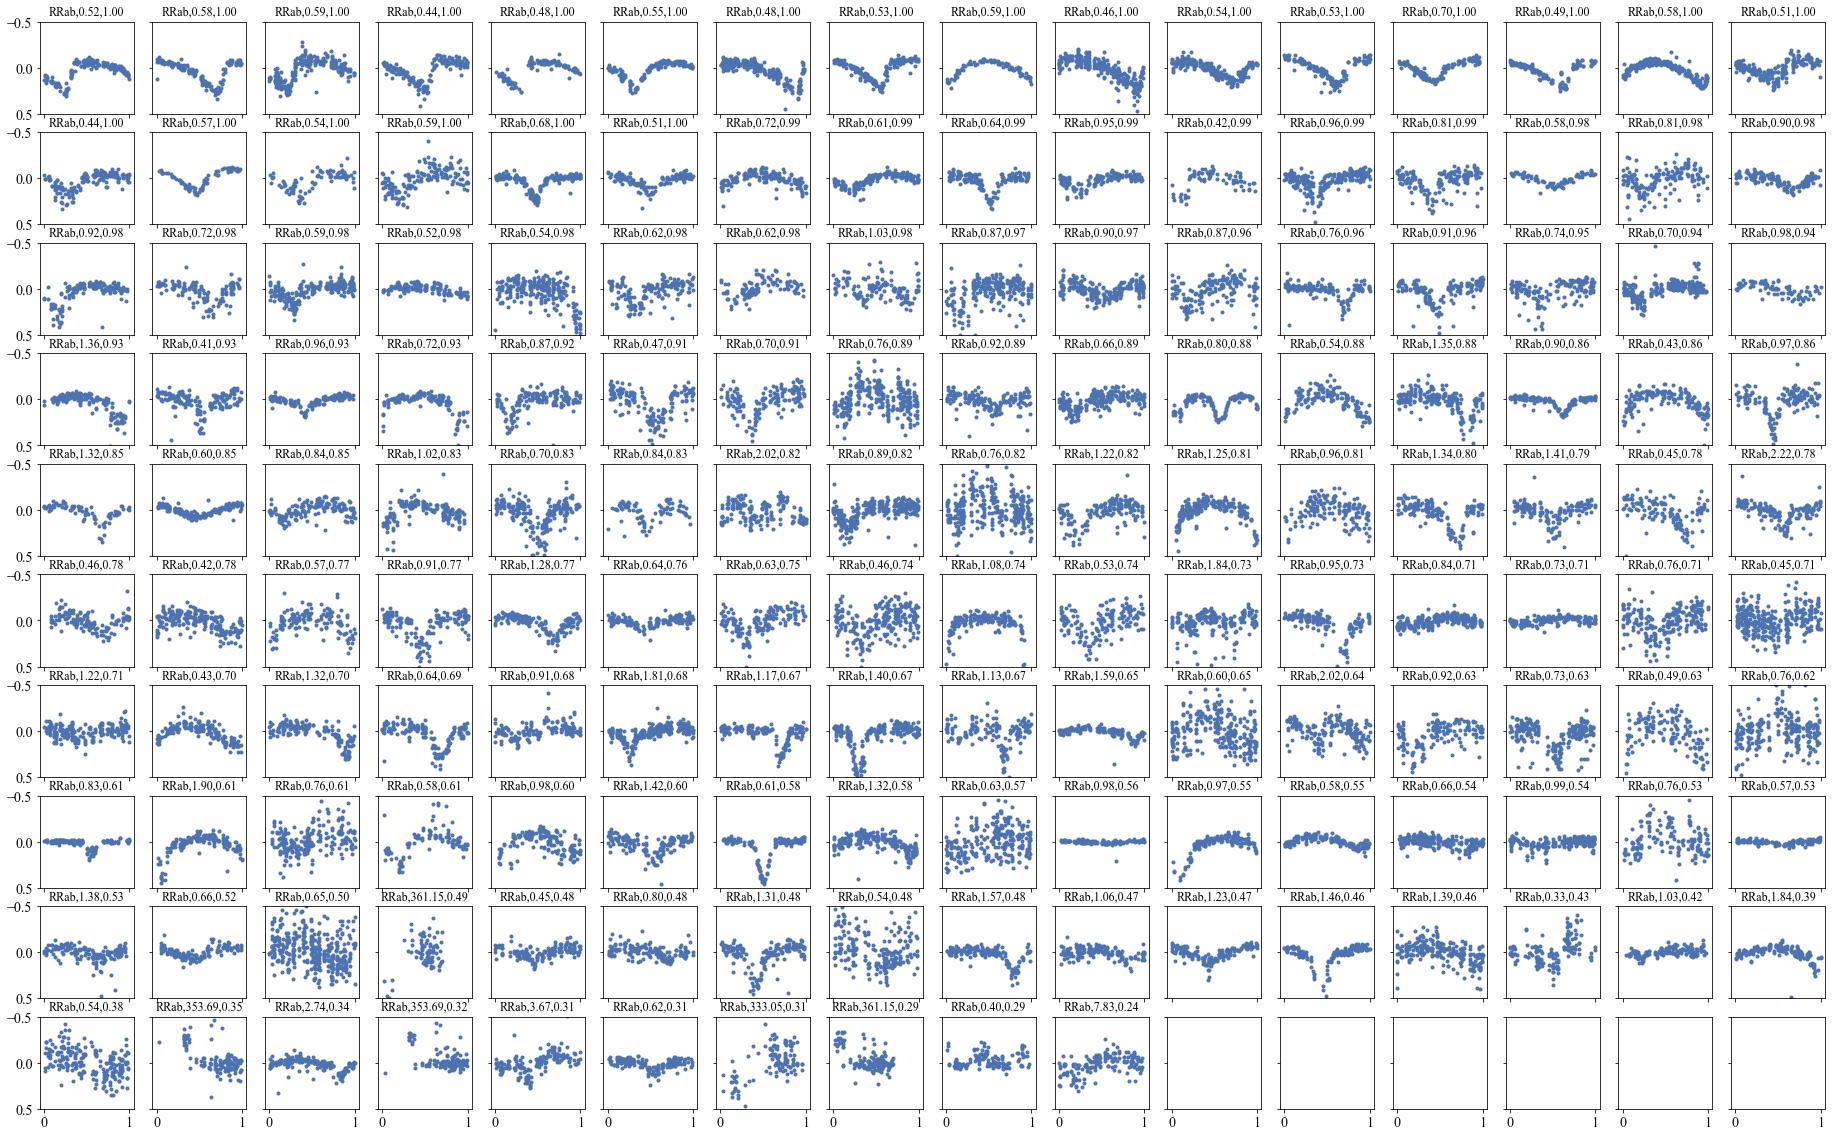

In [203]:
f,a=plt.subplots(10,16,figsize=[32,20],sharex=True,sharey=True)
a = a.flatten()
for ii in range(len(unmatched)):
    plt.sca(a[ii])
    sid,per,clss=unmatched['sourceid'].values[ii],unmatched['lsq_period'].values[ii],unmatched['class'].values[ii]
    lc=get_lightcurve(sid)
    prb=unmatched['prob'].values[ii]
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<13.)#&(lc['chi']<3.)
    plt.plot((lc['mjdobs'][clean]%(per)/per),lc['mag'][clean]-np.nanmedian(lc['mag'][clean]),'.')
    plt.title('%s,%0.2f,%0.2f'%(clss,per,prb))
plt.ylim(-0.5,0.5)
plt.gca().invert_yaxis()

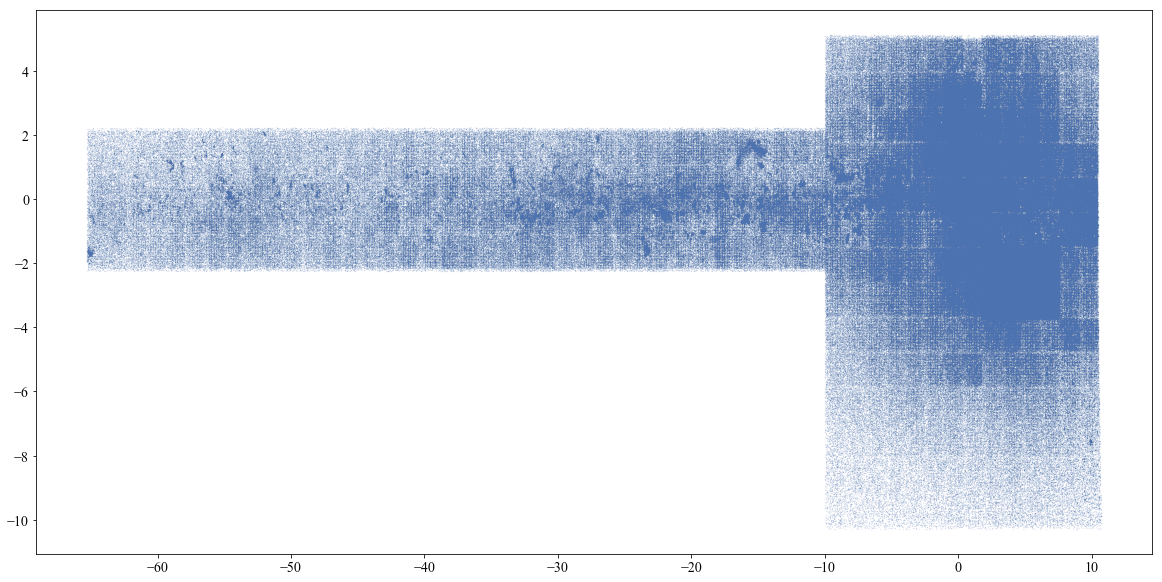

In [5]:
fltr = (data['prob']>0.)#&(data['class']=='RRab')
plt.figure(figsize=[20.,10.])
plt.plot((data['l']-360.*(data['l']>180.))[fltr], data['b'][fltr], '.',ms=0.1)

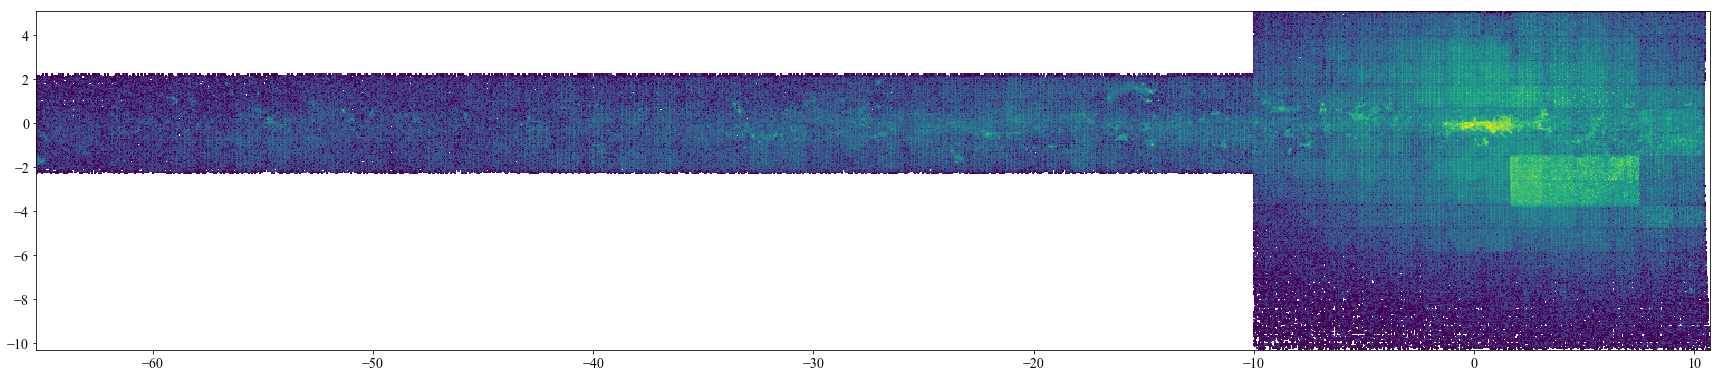

In [6]:
fltr = (data['prob']>0.)
plt.figure(figsize=[30.,10.])
plt.hist2d((data['l']-360.*(data['l']>180.))[fltr], data['b'][fltr],bins=[750*2,150*2],norm=LogNorm());
plt.gca().set_aspect('equal')

In [4]:
np.count_nonzero((data['prob']>0.9)&(data['class']=='RRab'))

52476

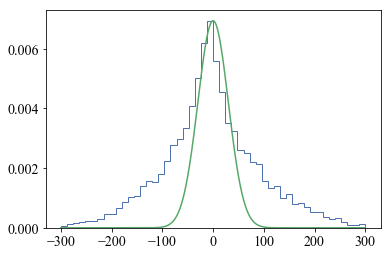

In [413]:
fltr = (data['prob']>0.9)&(data['class']=='RRab')&(data['l']<340.)&(data['epmb']<0.5)
n,b,p=plt.hist((data['pmb']*4.74*dist_rrab)[fltr],range=[-300,300],bins=50,histtype='step',density=True);
xx = np.linspace(-300,300,500)
plt.plot(xx, np.exp(-xx**2/30.**2/2.)*np.max(n))

52476


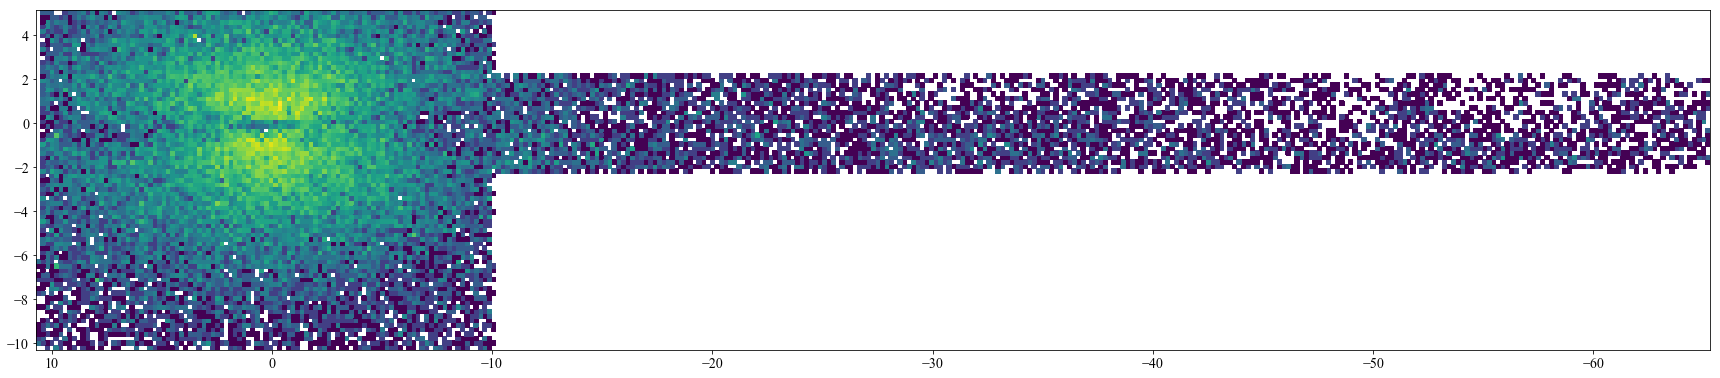

In [390]:
fltr = (data['prob']>0.9)&(data['class']=='RRab')
print(np.count_nonzero(fltr))
plt.figure(figsize=[30.,10.])
plt.hist2d((data['l']-360.*(data['l']>180.))[fltr], data['b'][fltr],bins=[750/2,150/2],norm=LogNorm());
plt.gca().set_aspect('equal')
plt.gca().invert_xaxis()

63981


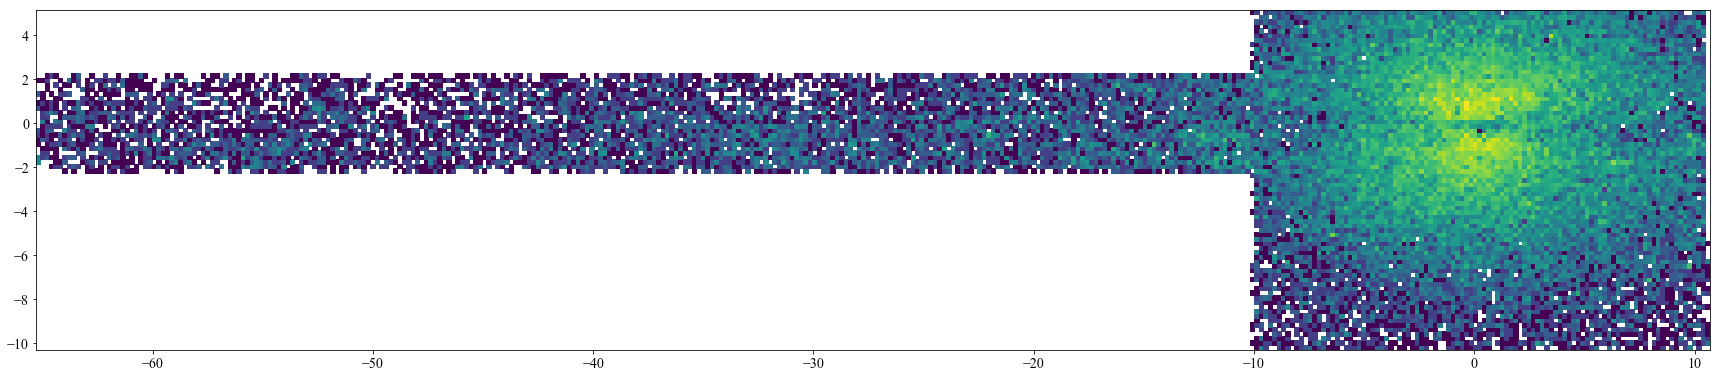

In [8]:
fltr = (data['prob']>0.8)&(data['class']=='RRab')
print(np.count_nonzero(fltr))
plt.figure(figsize=[30.,10.])
plt.hist2d((data['l']-360.*(data['l']>180.))[fltr], data['b'][fltr],bins=[750/2,150/2],norm=LogNorm());
plt.gca().set_aspect('equal')

134925


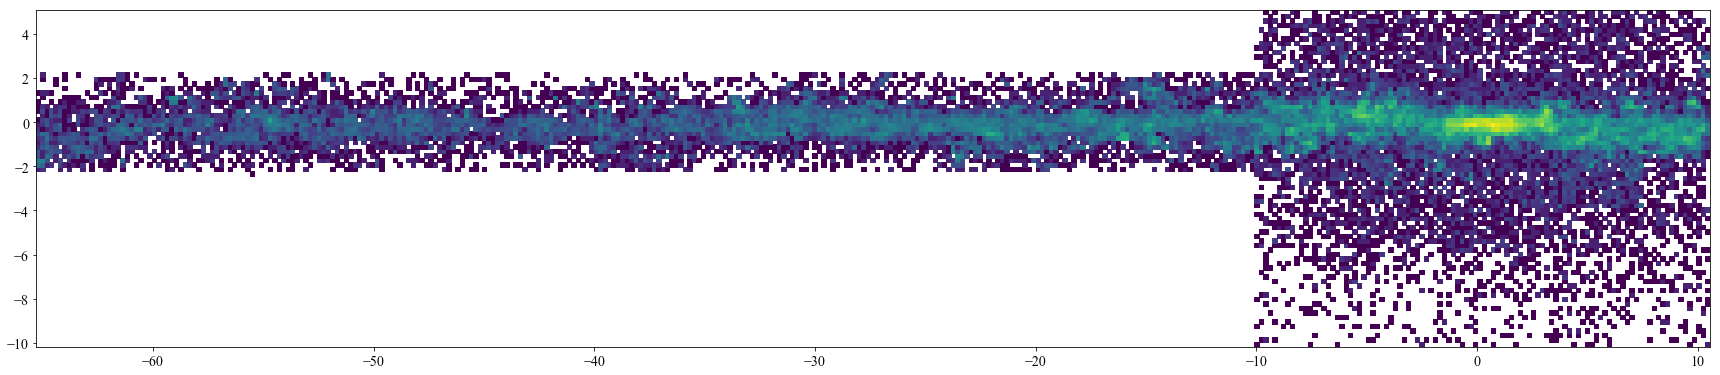

In [46]:
fltr = (data['prob']>0.9)&(data['class']=='LPV')#&(np.abs(data['b'])<1.)
print(np.count_nonzero(fltr))
plt.figure(figsize=[30.,10.])
plt.hist2d((data['l']-360.*(data['l']>180.))[fltr], data['b'][fltr],bins=[750/2,150/2],norm=LogNorm());
plt.gca().set_aspect('equal')

In [67]:
from plotting_general import col_norm

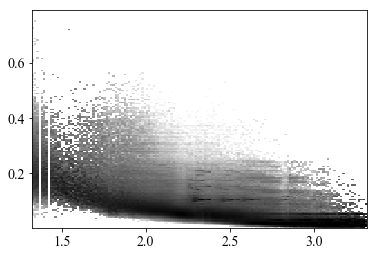

In [75]:
fltr = (data['prob']>0.)#&(data['lsq_period']>1300.)
col_norm(np.log10(data['n_epochs'])[fltr],data['max_phase_lag'][fltr],bins=150,norm=LogNorm());

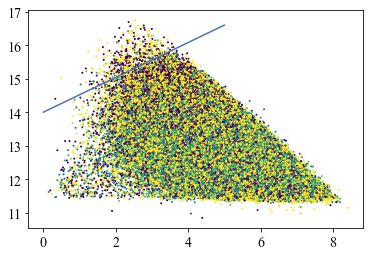

In [45]:
plt.scatter(data['j_ivw_mean_mag'][fltr]-data['ks_ivw_mean_mag'][fltr],data['ks_ivw_mean_mag'][fltr],
           c=data['parallax'][fltr],s=1,vmin=-1,vmax=1)
xx = np.array([0.,5.])
plt.plot(xx, 0.52*xx+14.)

# ejk, ak=0.52*ejk

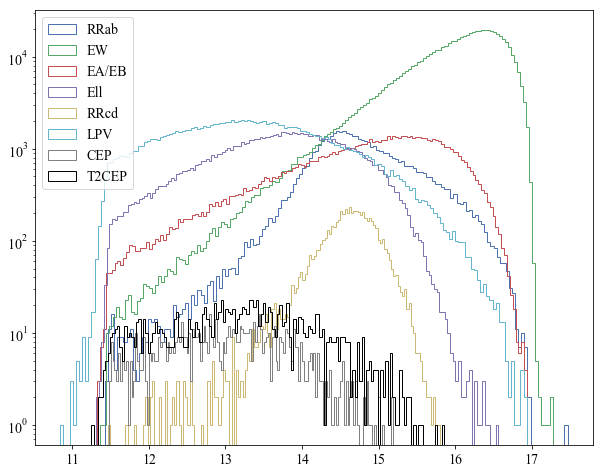

In [10]:
plt.figure(figsize=[10,8])
fltr = (data['prob']>0.9)
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='RRab')&fltr],bins=150,histtype='step',label='RRab');
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='EW')&fltr],bins=150,histtype='step',label='EW');
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='EA/EB')&fltr],bins=150,histtype='step',label='EA/EB');
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='Ell')&fltr],bins=150,histtype='step',label='Ell');
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='RRcd')&fltr],bins=150,histtype='step',label='RRcd');
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='LPV')&fltr],bins=150,histtype='step',label='LPV');
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='CEP')&fltr],bins=150,histtype='step',color='gray',label='CEP');
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='T2CEP')&fltr],bins=150,histtype='step',color='K',label='T2CEP');
plt.semilogy()
plt.legend(loc='upper left')

In [235]:
import sys
sys.path.append('../../../../')
from pm_transform import ml_mb

In [236]:
data = ml_mb(data)

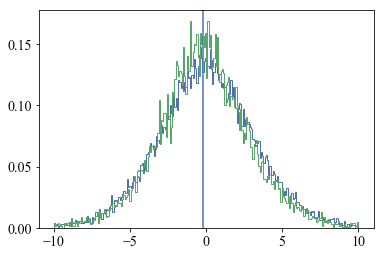

In [177]:
betw = lambda x, l, u: (x>l)&(x<u)
plt.hist(data['pmb'][(data['prob']>0.9)&(data['class']=='RRab')
                     &betw(np.abs(data['l']-360.*(data['l']>180.)),0.,5.)],
        range=[-10,10],bins=250,histtype='step',normed=True);
plt.hist(data['pmb'][(data['prob']>0.9)&(data['class']=='RRab')
                     &betw(np.abs(data['l']-360.*(data['l']>180.)),5.,10.)],
        range=[-10,10],bins=250,histtype='step',normed=True);
plt.axvline(-7.25/4.74/8.18)

17649


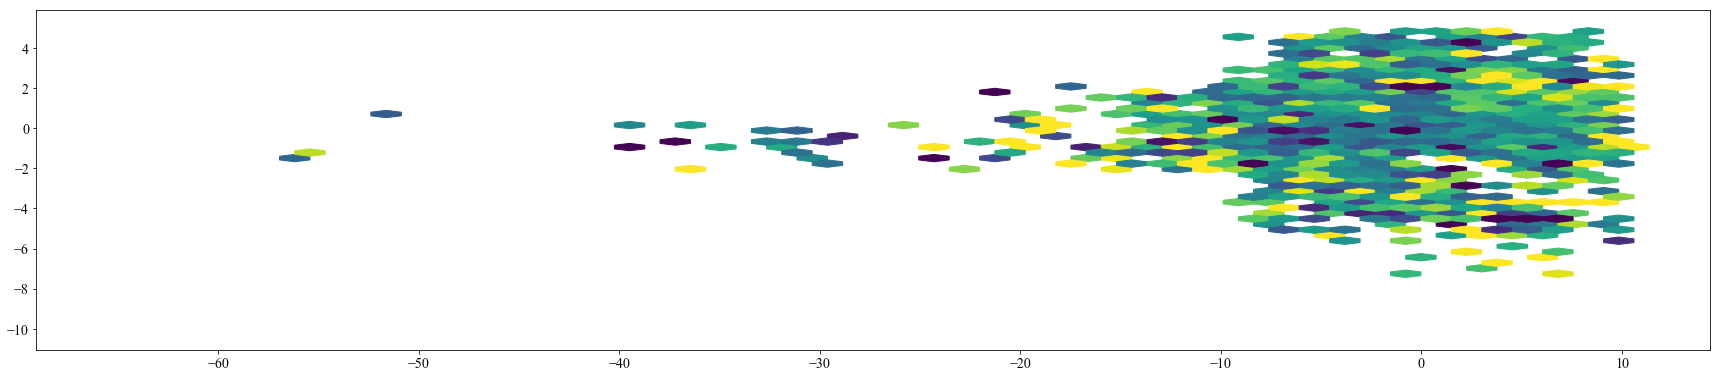

In [140]:
fltr = (data['prob']>0.9)&(data['class']=='RRab')&(data['ks_ivw_mean_mag']>15.)&(data['ks_ivw_mean_mag']<17.)
print(np.count_nonzero(fltr))
plt.figure(figsize=[30.,10.])
plt.hexbin((data['l']-360.*(data['l']>180.))[fltr], data['b'][fltr],
           C=data['pml'][fltr],
#            reduce_C_function=np.nanstd,
           mincnt=10,
           gridsize=50,vmin=-8,vmax=-4);
plt.gca().set_aspect('equal')

In [180]:
np.count_nonzero((data['j_ivw_mean_mag']>0)&(data['class']=='RRab')&(data['prob']>0.9))

52476

In [211]:
def k_law(p):
    return -1.46-2.4*np.log10(p)
def j_law(p):
    return -0.97-1.58*np.log10(p)


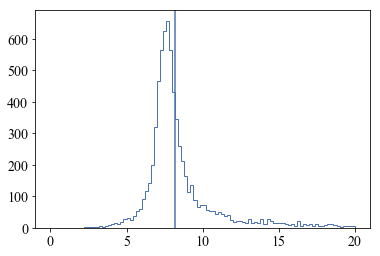

In [256]:
def wrap(l):
    return l-360.*(l>180.)

coeff=0.528
dist_rrab = np.power(10.,0.2*(
    data['ks_ivw_mean_mag']-coeff*(data['j_ivw_mean_mag']- data['ks_ivw_mean_mag'])
    +2.53*np.log10(data['lsq_period'])+1.03)-2)

plt.hist(dist_rrab[(data['class']=='RRab')&(data['prob']>0.95)
                   &(np.abs(wrap(data['l']))<2.)
                   &(np.abs(wrap(data['b']))>2.)],range=[0,20],histtype='step',bins=100);
plt.axvline(8.18)

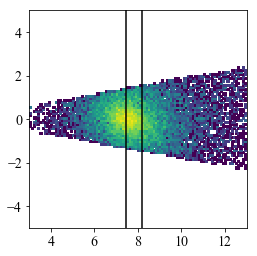

In [331]:
metal_rrl = -2.765
fltr = (data['class']=='RRab')&(data['prob']>0.95)&(np.abs(data['b'])>2.5)

coeff = 0.528
# coeff = 0.482
# coeff = 0.676
# coeff = 1.
# coeff = 0.482
dist_rrab = np.power(10.,0.2*(
    data['ks_ivw_mean_mag']-coeff*(data['j_ivw_mean_mag']- data['ks_ivw_mean_mag'])
    +2.53*np.log10(data['lsq_period'])+1.03)-2)

plt.hist2d((dist_rrab*np.cos(np.deg2rad(data['l']))*np.cos(np.deg2rad(data['b'])))[fltr],
           (dist_rrab*np.sin(np.deg2rad(data['l']))*np.cos(np.deg2rad(data['b'])))[fltr],
          range=[[3,13],[-5,5]],bins=100,norm=LogNorm());
plt.gca().set_aspect('equal')
plt.axvline(8.18,color='k')
plt.axvline(7.48,color='k')

In [350]:
from scipy.ndimage import gaussian_filter

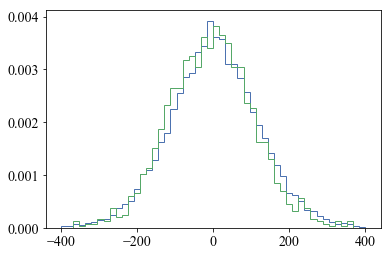

In [428]:
plt.hist((4.74*dist_rrab*(data['pmb']))[(data['class']=='RRab')&(data['prob']>0.95)
                                            &(np.abs(data['b'])<2.5)
                                        &(np.abs(wrap(data['l']))<10.)
                                       &(dist_rrab>6.)&(dist_rrab<10.)],
         normed=True,
        bins=50,range=[-400,400],histtype='step');
plt.hist((4.74*dist_rrab*(data['pmb']))[(data['class']=='RRab')
                                            &(data['prob']>0.95)&(np.abs(data['b'])>7.5)
                                        &(np.abs(wrap(data['l']))<10.)
                                       &(dist_rrab>6.)&(dist_rrab<10.)],
         normed=True,
        bins=50,range=[-400,400],histtype='step');

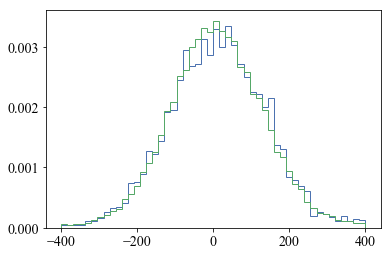

In [435]:
plt.hist((4.74*dist_rrab*(data['pml']+6.4))[(data['class']=='RRab')&(data['prob']>0.9)
                                            &(np.abs(data['b'])<1.)&(np.abs(wrap(data['l']))<10.)
                                       &(dist_rrab>6.)&(dist_rrab<10.)],
         normed=True,
        bins=50,range=[-400,400],histtype='step');
plt.hist((4.74*dist_rrab*(data['pml']+6.4))[(data['class']=='RRab')
                                            &(data['prob']>0.9)&(np.abs(data['b'])>0.5)
                                            &(np.abs(wrap(data['l']))<10.)
                                       &(dist_rrab>6.)&(dist_rrab<10.)],
         normed=True,
        bins=50,range=[-400,400],histtype='step');

/data/jls/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


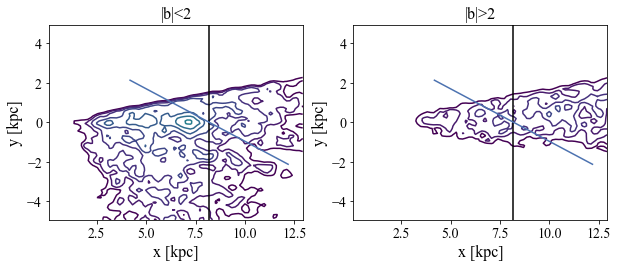

In [512]:
metal_rrl = -2.765

f,a=plt.subplots(1,2,figsize=[10,10])

def plot(fltr):
    coeff = 0.528
    # coeff = 0.482
    # coeff = 0.676
    # coeff = 1.
    # coeff = 0.482
    dist_rrab = np.power(10.,0.2*(
        data['ks_ivw_mean_mag']-coeff*(data['j_ivw_mean_mag']-data['ks_ivw_mean_mag'])
        +2.53*np.log10(data['lsq_period'])+1.03)-2)

    H,X,Y=np.histogram2d((dist_rrab*np.cos(np.deg2rad(data['l']))*np.cos(np.deg2rad(data['b'])))[fltr],
               (dist_rrab*np.sin(np.deg2rad(data['l']))*np.cos(np.deg2rad(data['b'])))[fltr],
              range=[[0,13],[-5,5]],bins=80)
    X,Y = np.meshgrid(.5*(X[1:]+X[:-1]), .5*(Y[1:]+Y[:-1]),indexing='ij')
    plt.contour(X,Y,np.log10(gaussian_filter(H,1)),levels=np.linspace(0.6,2.1,15));
    plt.gca().set_aspect('equal')
    plt.axvline(8.18,color='k')
    # plt.axvline(7.48,color='k')
    bar_angle = 28.
    xx = np.linspace(-4,4)
    plt.plot(xx+8.18,-np.tan(np.deg2rad(bar_angle))*xx)
    plt.xlabel('x [kpc]')
    plt.ylabel('y [kpc]')

plt.sca(a[0])
plt.title('|b|<2',fontsize=16)
fltr = (data['class']=='RRab')&(data['prob']<0.9)&(np.abs(data['b'])<2)#&(np.abs(data['pmb'])<2.5)
plot(fltr)
plt.sca(a[1])
plt.title('|b|>2',fontsize=16)
fltr = (data['class']=='RRab')&(data['prob']<0.9)&(np.abs(data['b'])>2)#&(np.abs(data['pmb'])<2.5)
plot(fltr)

In [505]:
np.count_nonzero((data['class']=='RRab')&(data['prob']>0.9)&(np.abs(data['b'])>2))

27223

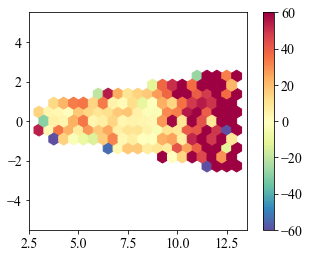

In [327]:
fltr = (data['prob']>0.85)&(data['class']=='RRab')&(np.abs(data['b'])>2.5)
# fltr &= (np.abs(data['b'])<2.)

plt.hexbin((dist_rrab*np.cos(np.deg2rad(data['l']))*np.cos(np.deg2rad(data['b'])))[fltr],
           (dist_rrab*np.sin(np.deg2rad(data['l']))*np.cos(np.deg2rad(data['b'])))[fltr],
           extent=[3,13,-5,5],
           gridsize=20,
           C=(4.74*dist_rrab*(data['pml']+6.4))[fltr],
           vmin=-60,vmax=60,cmap=plt.cm.Spectral_r);
plt.colorbar()
plt.gca().set_aspect('equal')

In [ ]:
Fe/H] = −3.142 − 4.902P + 0.824(φ31 + π)) 

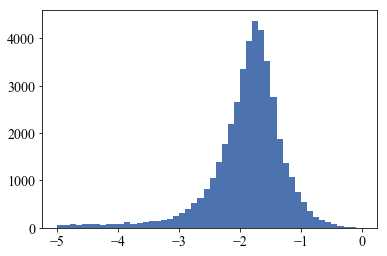

In [243]:
plt.hist((-3.142-4.902*data['lsq_period']+(np.remainder(data['phi_2']-3*data['phi_0'],2.*np.pi))*0.824)[fltr],bins=50,
        range=[-5,0]);

In [248]:
def metal(data):
    fl= np.remainder(data['phi_2']-3*data['phi_0'],2.*np.pi)
    fl[fl<np.pi]+=2*np.pi
    return -3.142 - 4.902*data['lsq_period'] + 0.824*fl

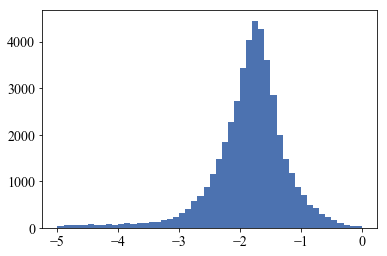

In [250]:
plt.hist(metal(data)[fltr],bins=50,range=[-5,0]);

## OGLE comparison

In [81]:
ogle4_rrl=pd.DataFrame(sqlutilpy.get('''select * from ogle4_rrl_bulge_disc''', **config.wsdb_kwargs))

In [90]:
from astropy.coordinates import SkyCoord
import astropy.units as u
ogle_skycoord = SkyCoord(ra=ogle4_rrl['ra']*u.deg, dec=ogle4_rrl['decl']*u.deg, frame='icrs').transform_to('galactic')
c = SkyCoord(ra=(data['ra'].values*u.degree-15.*u.yr*data['pmra'].values*u.mas/u.yr/np.cos(np.deg2rad(data['dec'].values))), 
             dec=(data['dec'].values*u.degree-15.*u.yr*data['pmdec'].values*u.mas/u.yr),frame='icrs')
catalog = SkyCoord(ra=ogle4_rrl['ra'].values*u.deg, dec=ogle4_rrl['decl'].values*u.deg,frame='icrs')
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
idx_ogle, d2d_ogle, d3d_ogle = catalog.match_to_catalog_sky(c)

Text(0.5, 1.0, 'VVV Prob>0.9')

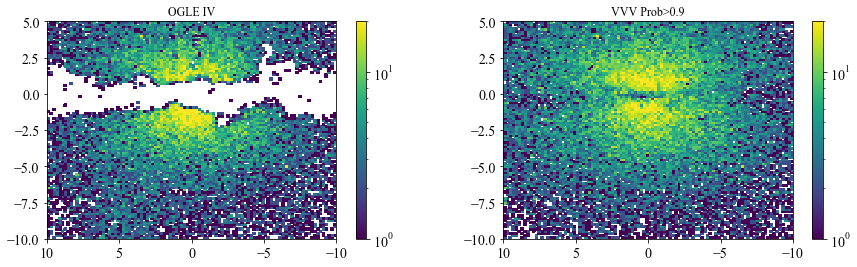

In [89]:
f,a=plt.subplots(1,2,figsize=[15.,4.])
plt.sca(a[0])
fltr = (ogle4_rrl['type']=='RRab')
plt.hist2d((ogle_skycoord.l.deg-360.*(ogle_skycoord.l.deg>180.))[fltr], ogle_skycoord.b.deg[fltr], range=[[-10,10],[-10,5]],bins=100,vmax=20,norm=LogNorm())
plt.xlim(-10,10)
plt.ylim(-10,5)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('OGLE IV')
plt.sca(a[1])
fltr = (data['class']=='RRab')&(data['prob']>0.9)
plt.hist2d((data['l']-360.*(data['l']>180.))[fltr], data['b'][fltr], range=[[-10,10],[-10,5]],bins=100,vmax=20,norm=LogNorm())
plt.xlim(-10,10)
plt.ylim(-10,5)
plt.gca().invert_xaxis()
plt.colorbar()
plt.gca().set_aspect('equal')
plt.title('VVV Prob>0.9')

Text(0.5, 0, 'Classification prob.')

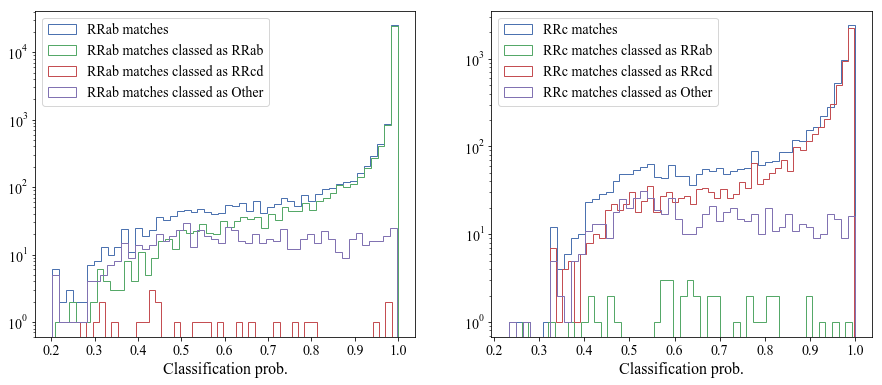

In [122]:
f,a=plt.subplots(1,2,figsize=[15.,6.])
plt.sca(a[0])
ogle_match = (d2d.arcsec<0.4)&(ogle4_rrl['type'].values[idx]=='RRab')
plt.hist(data['prob'][ogle_match],bins=50,histtype='step',label='RRab matches');
plt.hist(data['prob'][ogle_match&(data['class']=='RRab')],bins=50,histtype='step',label='RRab matches classed as RRab');
plt.hist(data['prob'][ogle_match&(data['class']=='RRcd')],bins=50,histtype='step',label='RRab matches classed as RRcd');
plt.hist(data['prob'][ogle_match&((data['class']!='RRcd')&(data['class']!='RRab'))],label='RRab matches classed as Other',
         bins=50,histtype='step');
plt.legend(loc='upper left')
plt.semilogy()
plt.xlabel('Classification prob.')

plt.sca(a[1])
ogle_match = (d2d.arcsec<0.4)&(ogle4_rrl['type'].values[idx]=='RRc')
plt.hist(data['prob'][ogle_match],bins=50,histtype='step',label='RRc matches');
plt.hist(data['prob'][ogle_match&(data['class']=='RRab')],bins=50,histtype='step',label='RRc matches classed as RRab');
plt.hist(data['prob'][ogle_match&(data['class']=='RRcd')],bins=50,histtype='step',label='RRc matches classed as RRcd');
plt.hist(data['prob'][ogle_match&((data['class']!='RRcd')&(data['class']!='RRab'))],label='RRc matches classed as Other',
         bins=50,histtype='step');
plt.semilogy()
plt.legend(loc='upper left')
plt.xlabel('Classification prob.')

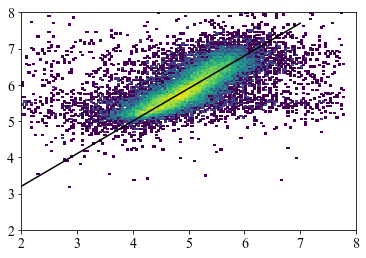

In [206]:
ogle_match = (d2d.arcsec<0.4)&(ogle4_rrl['type'].values[idx]=='RRab')&(data['prob']>0.9)

def wrap_phi(x):
    x = np.remainder(x, 2.*np.pi)
    return x+(x<1.5)*2.*np.pi

plt.hist2d(wrap_phi(data['phi_2']-3*data['phi_0']).values[ogle_match],
         (ogle4_rrl['phi31_1'].values+np.pi)[idx[ogle_match]],range=[[2,8.],[2,8]],bins=150,
          norm=LogNorm())
xx = np.linspace(0.,7.)
plt.plot(xx,0.9*(xx-5.)+5.9,color='k')

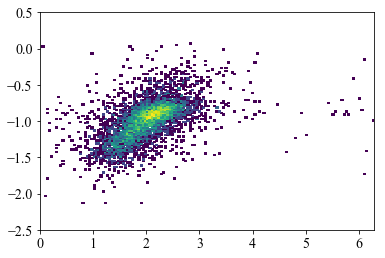

In [207]:
def metal_ogle_I(ogle):
    return -3.142-4.902*ogle['p_1'].values + 0.824 * (ogle['phi31_1'].values+np.pi)

def metal_vvv_K(data):
    return -3.142-4.902*data['lsq_period'].values + 0.824 * (0.9*(wrap_phi(data['phi_2']-3*data['phi_0'])-5)+5.9)

ogle_match = (d2d.arcsec<0.4)&(ogle4_rrl['type'].values[idx]=='RRab')&(data['prob']>0.9)&(data['class']=='RRab')\
&(data['lsq_period']>0.55)&(data['lsq_period']<0.6)
# &(ogle4_rrl['p_1'].values[idx]>0.55)&(ogle4_rrl['p_1'].values[idx]<0.6)
#             &(data['lsq_period']>0.4)&(data['lsq_period']<0.45)


plt.hist2d(np.remainder((data['phi_2']-3*data['phi_0']-np.pi).values[ogle_match],2.*np.pi),
         metal_ogle_I(ogle4_rrl)[idx[ogle_match]],range=[[0.,2*np.pi],[-2.5,0.5]],bins=150,
          norm=LogNorm()
          );

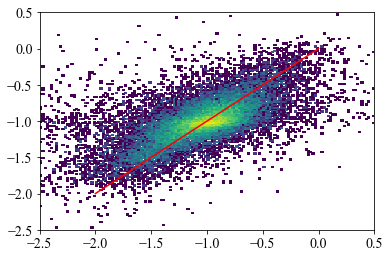

In [208]:
ogle_match = (d2d.arcsec<0.4)&(ogle4_rrl['type'].values[idx]=='RRab')&(data['prob']>0.9)&(data['class']=='RRab')
plt.hist2d(metal_vvv_K(data)[ogle_match],
         metal_ogle_I(ogle4_rrl)[idx[ogle_match]],range=[[-2.5,0.5],[-2.5,0.5]],bins=150,
          norm=LogNorm()
          );
xx = np.linspace(-2,0.)
plt.plot(xx,xx,color='r')

In [219]:
from plotting_general import col_norm, row_norm

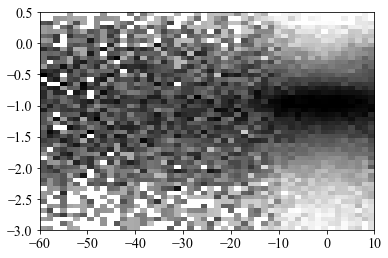

In [229]:
col_norm((data['l']-360.*(data['l']>180.))[(data['class']=='RRab')&(data['prob']>0.9)],metal_vvv_K(data)[(data['class']=='RRab')&(data['prob']>0.9)],
          range=[[-60,10],[-3,0.5]],bins=50,norm=LogNorm());

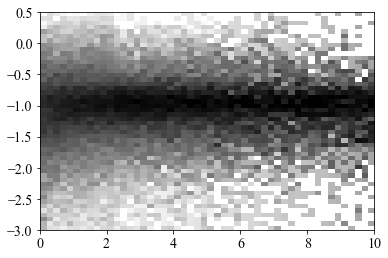

In [231]:
col_norm(np.abs(data['b'])[(data['class']=='RRab')&(data['prob']>0.9)],metal_vvv_K(data)[(data['class']=='RRab')&(data['prob']>0.9)],
          range=[[0,10],[-3,0.5]],bins=50,norm=LogNorm());

/data/jls/python3.5/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


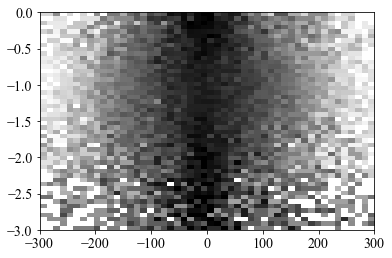

In [262]:
coeff=0.528
dist_rrab = np.power(10.,0.2*(
    data['ks_ivw_mean_mag']-coeff*(data['j_ivw_mean_mag']- data['ks_ivw_mean_mag'])
    +2.53*np.log10(data['lsq_period'])+1.03)-2)

betw = lambda x, l, u: (x>l)&(x>u)
row_norm((4.74*dist_rrab*data['pmb'])[(data['class']=='RRab')&(data['prob']>0.9)],metal_vvv_K(data)[(data['class']=='RRab')&(data['prob']>0.9)],
          range=[[-300,300],[-3.,0.]],bins=50,norm=LogNorm());

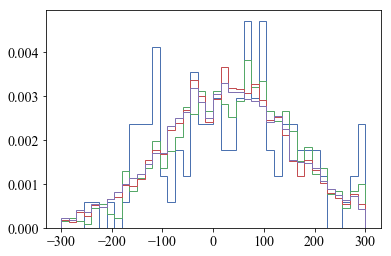

In [287]:
kfltr = (data['class']=='RRab')&(data['prob']>0.95)&(np.abs(data['l']-360.*(data['l']>180.))<10.)&(data['lsq_period']>0.65)
plt.hist(
    (4.74*dist_rrab*(data['pml']+6.4))[kfltr&betw(metal_vvv_K(data),-1.,-0.5)],
    range=[-300,300],histtype='step',bins=40,density=True
);
plt.hist(
    (4.74*dist_rrab*(data['pml']+6.4))[kfltr&betw(metal_vvv_K(data),-1.5,-1.0)],
    range=[-300,300],histtype='step',bins=40,density=True
);
plt.hist(
    (4.74*dist_rrab*(data['pml']+6.4))[kfltr&betw(metal_vvv_K(data),-2.,-1.5)],
    range=[-300,300],histtype='step',bins=40,density=True
);

plt.hist(
    (4.74*dist_rrab*(data['pml']+6.4))[kfltr&betw(metal_vvv_K(data),-2.5,-2.)],
    range=[-300,300],histtype='step',bins=40,density=True
);


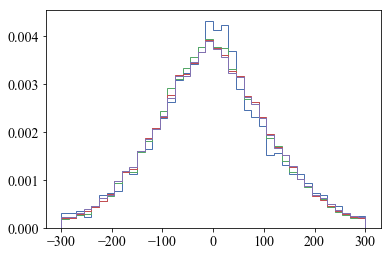

In [274]:
kfltr = (data['class']=='RRab')&(data['prob']>0.9)&(np.abs(data['l']-360.*(data['l']>180.))<10.)
plt.hist(
    (4.74*dist_rrab*data['pmb'])[kfltr&betw(metal_vvv_K(data),-1,-0.5)],
    range=[-300,300],histtype='step',bins=40,density=True
);
plt.hist(
    (4.74*dist_rrab*data['pmb'])[kfltr&betw(metal_vvv_K(data),-1.5,-1.0)],
    range=[-300,300],histtype='step',bins=40,density=True
);
plt.hist(
    (4.74*dist_rrab*data['pmb'])[kfltr&betw(metal_vvv_K(data),-2.,-1.5)],
    range=[-300,300],histtype='step',bins=40,density=True
);

plt.hist(
    (4.74*dist_rrab*data['pmb'])[kfltr&betw(metal_vvv_K(data),-2.5,-2.)],
    range=[-300,300],histtype='step',bins=40,density=True
);


In [ ]:
plt.hist(np.remainder(data['phi_2']-3*data['phi_0']-np.pi,2.*np.pi)[(data['class']=='RRab')&(data['prob']>0.99)],
         bins=250,range=[0,2*np.pi],histtype='step',normed=True);
plt.hist(ogle_rrl['phi31_1'][(ogle_rrl['Type']=='RRab')],bins=250,histtype='step',range=[0,2.*np.pi],normed=True);

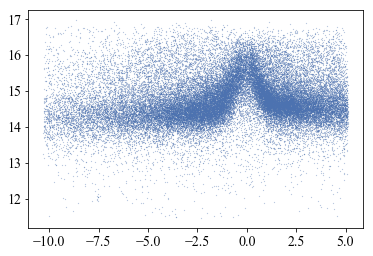

In [624]:
fltr = (data['class']=='RRab')&(data['prob']>0.9)&((data['l']<10.)|(data['l']>350.))
plt.plot(data['b'][fltr],data['ks_ivw_mean_mag'][fltr],'.',ms=0.3)

43991
31689


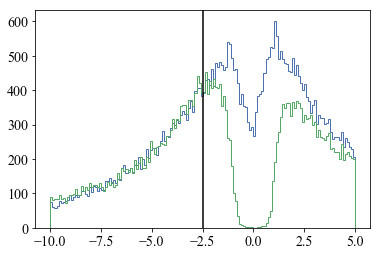

In [619]:
fltr = (data['class']=='RRab')&(data['prob']>0.9)&((data['l']<10.)|(data['l']>350.))
print(np.count_nonzero(fltr))
plt.hist(data['b'][fltr],bins=150,range=[-10,5],histtype='step');

fltr = (ogle_rrl['Type']=='RRab')&((s.l.deg<10.)|(s.l.deg>350.))&(s.b.deg>-10.)&(s.b.deg<5.)
print(np.count_nonzero(fltr))
plt.hist(s.b.deg[fltr],bins=150,range=[-10,5],histtype='step');
plt.axvline(-2.5,color='k')

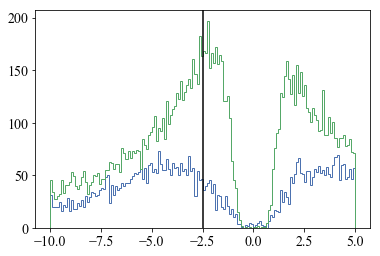

In [612]:
fltr = (data['class']=='RRcd')&(data['prob']>0.9)&((data['l']<10.)|(data['l']>350.))
plt.hist(data['b'][fltr],bins=150,range=[-10,5],histtype='step');

fltr = ((ogle_rrl['Type']=='RRc')|(ogle_rrl['Type']=='RRd'))&((s.l.deg<10.)|(s.l.deg>350.))
plt.hist(s.b.deg[fltr],bins=150,range=[-10,5],histtype='step');
plt.axvline(-2.5,color='k')

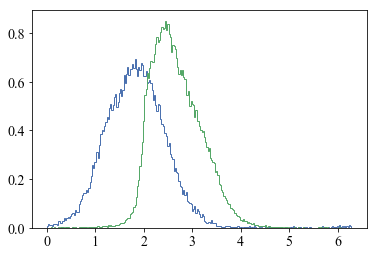

In [684]:
plt.hist(np.remainder(data['phi_2']-3*data['phi_0']-np.pi,2.*np.pi)[(data['class']=='RRab')&(data['prob']>0.99)],bins=250,range=[0,2*np.pi],histtype='step',normed=True);
plt.hist(ogle_rrl['phi31_1'][(ogle_rrl['Type']=='RRab')],bins=250,histtype='step',range=[0,2.*np.pi],normed=True);

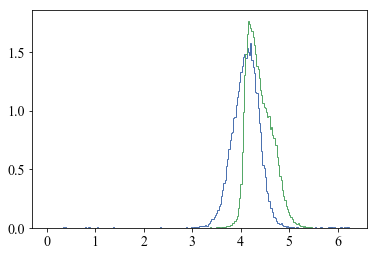

In [681]:
plt.hist(np.remainder(data['phi_1']-2*data['phi_0']-np.pi/2.,2.*np.pi)[(data['class']=='RRab')&(data['prob']>0.99)],bins=250,range=[0,2*np.pi],histtype='step',normed=True);
plt.hist(ogle_rrl['phi21_1'][(ogle_rrl['Type']=='RRab')],bins=250,histtype='step',range=[0,2.*np.pi],normed=True);

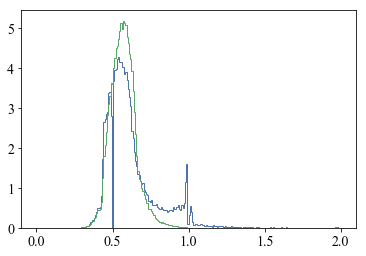

In [659]:
plt.hist(data['lsq_period'][(data['class']=='RRab')&(data['prob']>0.9)],bins=250,range=[0,2],histtype='step',normed=True);
plt.hist(ogle_rrl['P_1'][(ogle_rrl['Type']=='RRab')],bins=250,histtype='step',range=[0,2],normed=True);

In [746]:
c = SkyCoord(ra=(data['ra'].values*u.degree-15.*u.yr*data['pmra'].values*u.mas/u.yr/np.cos(np.deg2rad(data['dec'].values))), 
             dec=(data['dec'].values*u.degree-15.*u.yr*data['pmdec'].values*u.mas/u.yr),frame='icrs')
catalog = SkyCoord(ra=ogle4_rrl['ra'].values/24.*360.*u.deg, dec=ogle4_rrl['decl'].values*u.deg,frame='icrs')
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
idx_ogle, d2d_ogle, d3d_ogle = catalog.match_to_catalog_sky(c)

In [775]:
len(idx_ogle), len(ogle4_rrl)

(126146, 126146)

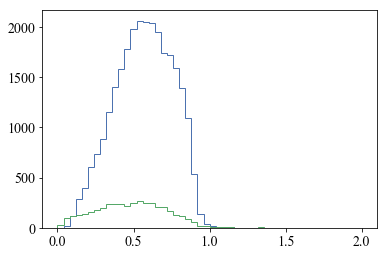

In [810]:
plt.hist(ogle4_rrl['a_1'][(d2d_ogle.arcsec<0.4)&(ogle4_rrl['type']=='RRab')&bulge_region],histtype='step',bins=50,range=[0,2]);
plt.hist(ogle4_rrl['a_1'][(d2d_ogle.arcsec>0.4)&(ogle4_rrl['type']=='RRab')&bulge_region],bins=50,histtype='step',range=[0,2]);

In [828]:
from virac_utils import cm_virac

In [983]:
ogle4_v_match=cm_virac(ogle4_rrl[bulge_region], 
                       radeccols=['ra', 'decl'], use_pm=False, cm_radius=0.4)

/data/jls/python3.5/site-packages/sqlutilpy/sqlutil.py:398: UserWarning: Column name sourceid is repeated in the output, new name sourceid_1 assigned
  'new name %s assigned') % (_n, curn))
/data/jls/python3.5/site-packages/sqlutilpy/sqlutil.py:398: UserWarning: Column name l is repeated in the output, new name l_1 assigned
  'new name %s assigned') % (_n, curn))
/data/jls/python3.5/site-packages/sqlutilpy/sqlutil.py:398: UserWarning: Column name b is repeated in the output, new name b_1 assigned
  'new name %s assigned') % (_n, curn))


In [892]:
len(ogle4_v_match),\
np.count_nonzero((ogle4_v_match['ks_b_ivw_mean_mag']>11.5)&(ogle4_v_match['ks_b_ivw_mean_mag']<17.)
                &(ogle4_v_match['ks_n_detections']>20)), \
np.count_nonzero(bulge_region&(ogle4_rrl['type']=='RRab'))

(31312, 30631, 31312)

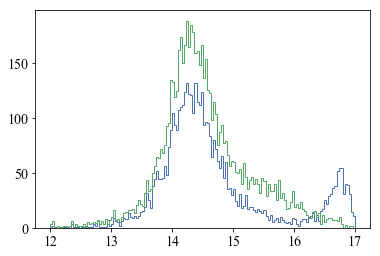

In [982]:
clss = 'RRab'
plt.hist(ogle4_v_match['ks_b_ivw_mean_mag'][(ogle4_v_match['ks_b_ivw_mean_mag']>11.5)
                                            &(ogle4_v_match['ks_b_ivw_mean_mag']<17.)
                &(ogle4_v_match['ks_n_detections']>20)&(ogle4_v_match['b']<-5.)&(ogle4_rrl['type']=='RRab')],bins=150,histtype='step',range=[12,17]);
bulge_region_data = ((data['l']<10)|(data['l']>350.))&(data['b']<5)&(data['b']>-10)
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='RRab')&(data['prob']>0.9)&bulge_region_data&(data['b']<-5.)],bins=150,range=[12,17],
                 weights=1./(.5*(1-np.tanh((data['ks_ivw_mean_mag'][(data['class']=='RRab')&(data['prob']>0.9)&bulge_region_data&(data['b']<-5.)]-18.)/1.5))),
        histtype='step');

/data/jls/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


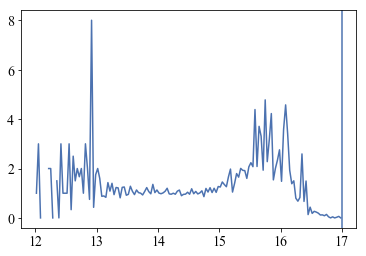

In [973]:
n,b=np.histogram(ogle4_v_match['ks_b_ivw_mean_mag'][(ogle4_v_match['ks_b_ivw_mean_mag']>11.5)
                                            &(ogle4_v_match['ks_b_ivw_mean_mag']<17.)
                &(ogle4_v_match['ks_n_detections']>20)&(ogle4_v_match['b']<-5.)],bins=150,range=[12,17]);
bulge_region_data = ((data['l']<10)|(data['l']>350.))&(data['b']<5)&(data['b']>-10)
n2,b=np.histogram(data['ks_ivw_mean_mag'][(data['class']=='RRab')&(data['prob']>0.9)&bulge_region_data&(data['b']<-5.)],bins=150,range=[12,17],
                 weights=1./(.5*(1-np.tanh((data['ks_ivw_mean_mag'][(data['class']=='RRab')&(data['prob']>0.9)&bulge_region_data&(data['b']<-5.)]-18.)/1.5))))
plt.plot(.5*(b[1:]+b[:-1]),n2/n)
plt.axvline(17.)

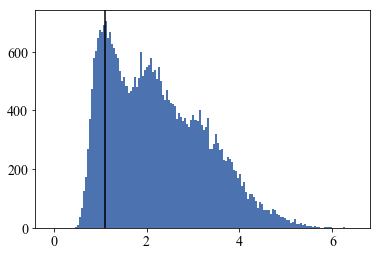

In [825]:
plt.hist(ogle4_rrl['i'][d2d_ogle.arcsec<0.4]-data['ks_ivw_mean_mag'].values[idx_ogle[d2d_ogle.arcsec<0.4]],bins=150);
plt.axvline(1.1,color='k')

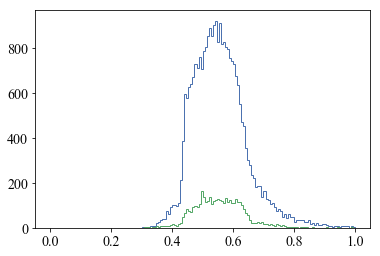

In [895]:
plt.hist(ogle4_rrl['p_1'][(d2d_ogle.arcsec<0.4)&(ogle4_rrl['type']=='RRab')&bulge_region],histtype='step',bins=150,range=[0,1]);
plt.hist(ogle4_rrl['p_1'][(d2d_ogle.arcsec>0.4)&(ogle4_rrl['type']=='RRab')&bulge_region],bins=150,histtype='step',range=[0,1]);

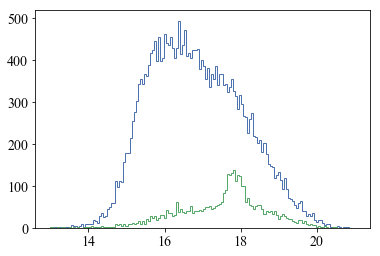

In [919]:
plt.hist(ogle4_rrl['i'][(d2d_ogle.arcsec<0.4)&(ogle4_rrl['type']=='RRab')&bulge_region],histtype='step',bins=150,
         range=[13,21]);
plt.hist(ogle4_rrl['i'][(d2d_ogle.arcsec>0.4)&(ogle4_rrl['type']=='RRab')&bulge_region],bins=150,histtype='step',
         range=[13,21]);

In [888]:
np.count_nonzero(data['prob_1st_stage'].values[idx_ogle[d2d_ogle.arcsec<0.4]]<0.7)

665

[]

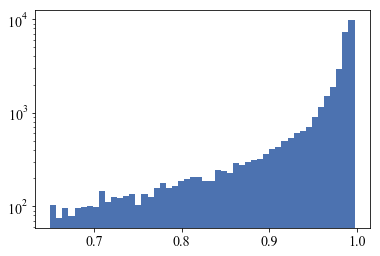

In [887]:
plt.hist(data['prob_1st_stage'].values[idx_ogle[d2d_ogle.arcsec<0.4]],bins=50);
plt.semilogy()

Text(0, 0.5, 'Completeness relative to OGLE 4 RRab in Bulge')

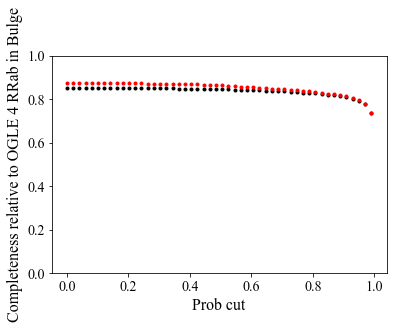

In [807]:
bulge_region = ((s.l.deg<10)|(s.l.deg>350.))&(s.b.deg<5)&(s.b.deg>-10)
prob_thresh=np.linspace(0.,0.99,50)
for p in prob_thresh:
    plt.plot([p],
    [np.count_nonzero((d2d_ogle.arcsec<0.4)&(ogle4_rrl['type']=='RRab')&bulge_region&(data['prob'].values[idx_ogle]>p)
                     &(data['class'].values[idx_ogle]=='RRab'))/\
        np.count_nonzero((ogle4_rrl['type']=='RRab')&bulge_region)],'k.')
    plt.plot([p],
    [np.count_nonzero((d2d_ogle.arcsec<0.4)&(ogle4_rrl['type']=='RRab')&bulge_region&(data['prob'].values[idx_ogle]>p))/\
        np.count_nonzero((ogle4_rrl['type']=='RRab')&bulge_region)],'r.')
plt.ylim(0.,1.)
plt.xlabel('Prob cut')
plt.ylabel('Completeness relative to OGLE 4 RRab in Bulge')

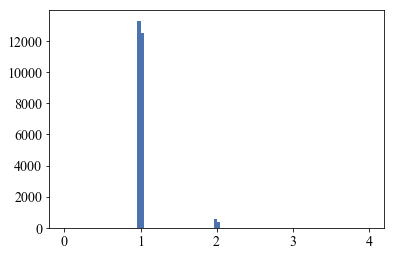

In [918]:
fltr = (data['class']=='RRab')&(data['prob']>0.9)&(d2d<0.4*u.arcsec)
plt.hist(data['lsq_period'].values[fltr]/ogle4_rrl['p_1'].values[idx][fltr],range=[0,4],bins=100);

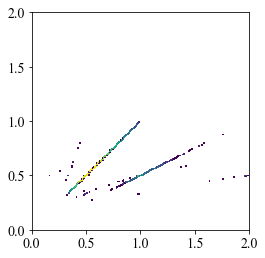

In [747]:
fltr = (data['class']=='RRab')&(data['prob']>0.9)&(d2d<0.4*u.arcsec)
plt.hist2d(data['lsq_period'].values[fltr],ogle4_rrl['p_1'].values[idx][fltr],range=[[0.,2.],[0.,2.]],norm=LogNorm(),bins=250);
plt.gca().set_aspect('equal')

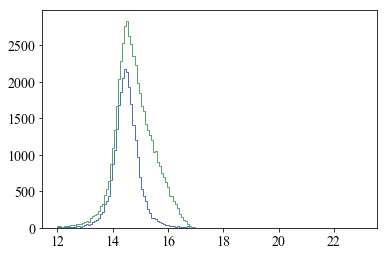

In [928]:
p=0.9
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='RRab')&(data['prob']>p)&(d2d<0.4*u.arcsec)],bins=150,histtype='step',
        range=[12.,23.])
plt.hist(data['ks_ivw_mean_mag'][(data['class']=='RRab')&(data['prob']>p)],bins=150,histtype='step',
        range=[12.,23.]);

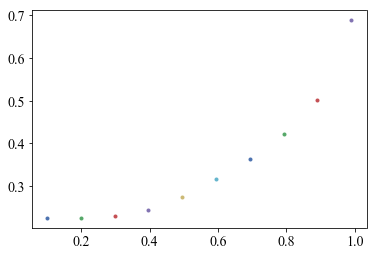

In [750]:
prob_thresh=np.linspace(0.1,0.99,10)
for p in prob_thresh:
    plt.plot([p],[np.count_nonzero((data['class']=='RRab')&(data['prob']>p)&(d2d<0.4*u.arcsec))/\
                  np.count_nonzero((data['class']=='RRab')&(data['prob']>p))], '.')

(3, 5.0)

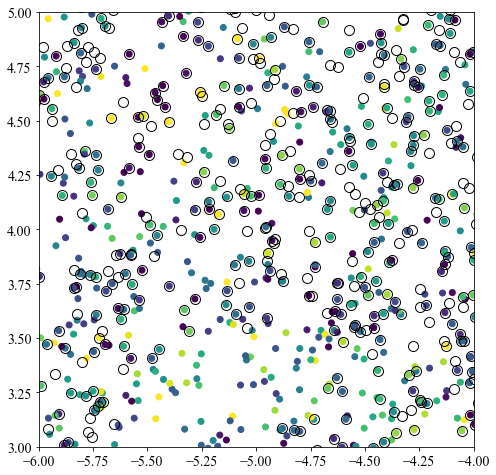

In [709]:
plt.figure(figsize=[8.,8.])
fltr = (ogle_rrl['Type']=='RRab')
plt.plot((s.l.deg-360.*(s.l.deg>180.))[fltr], s.b.deg[fltr],'ko',ms=10,mfc='none')
plt.xlim(-10,10)
plt.ylim(-10,5)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')
fltr = (data['class']=='RRab')&(data['prob']>0.9)
plt.scatter((data['l']-360.*(data['l']>180.))[fltr], data['b'][fltr], c=data['pml'][fltr],vmin=-10,vmax=0)
plt.xlim(-6,-4)
plt.ylim(3,5.)

In [ ]:
J &= (-0.97\pm 0.05) - (1.58\pm 0.17) \log_{10} P,\\
K_s &= (-1.46\pm 0.04) - (2.40\pm 0.1) \log_{10} P.